<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/baselinebandpower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [1]:
!pip -q install einops tqdm scikit-learn scipy





In [2]:
import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## --- Repo EEGPT ---

In [3]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [5]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [6]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [7]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


# EEGPT on the true dataset

## ridefiniamo build all usando rec_id

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [8]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 100.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    T = X.shape[0]
    t = np.arange(T) / 250.0

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza

    # 1) preprocess leggero a 250 (opzionale, ma ok)
    x = detrend(X, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # 2) resample 250 -> 256
    x = resample_to(x, fs_in, FS_OUT)               # (T256, C)
    t_256 = t[0] + np.arange(x.shape[0]) / FS_OUT   # (T256,)

    # 3) filtri a 256 (coerenti col segnale)
    x = bandpass(x, FS_OUT)
    x = notch50(x, FS_OUT)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t, X[:, ch_idx], '.', alpha=0.4, label="original (250 Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4) epoche a 256
    epochs_tc = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs_tc.shape[0] == 0:
        win = int(EPOCH_SEC * FS_OUT)
        return np.empty((0, X.shape[1], win), dtype=np.float32), None

    epochs = np.transpose(epochs_tc, (0, 2, 1))  # (N, C, win)

    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_256[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


    # 5) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)
    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs





    return epochs.astype(np.float32)

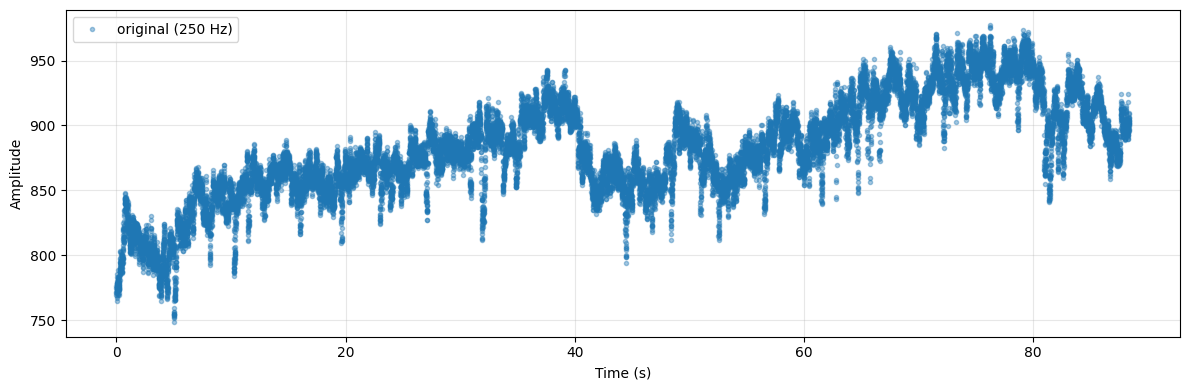

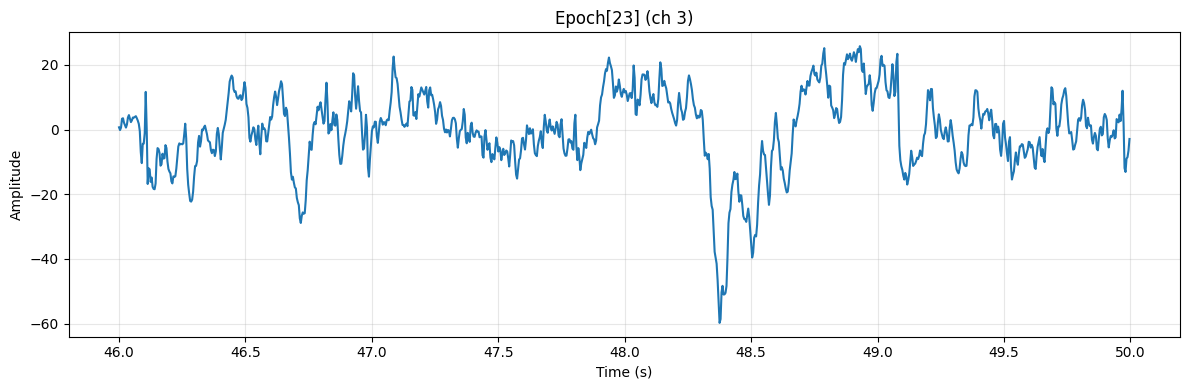

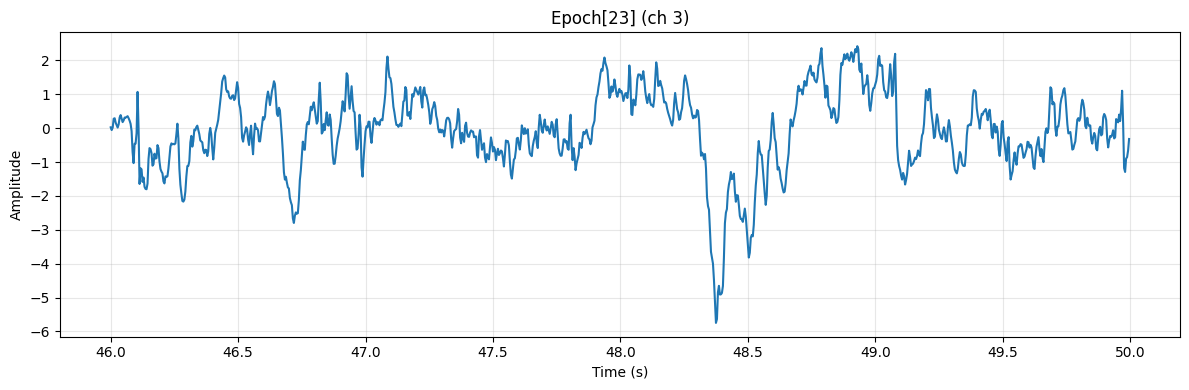

(43, 8, 1024)


In [10]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)




## build_all

In [11]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:

                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)

                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li]*len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


## baseline bandpower

In [12]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [13]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial",
            class_weight="balanced"
        )

        sub_tr = groups[tr]
        counts = pd.Series(sub_tr).value_counts()
        w = np.array([1.0 / counts[s] for s in sub_tr])

        clf.fit(Xtr, y_all[tr], sample_weight=w)


        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [14]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.218 | f1m=0.178
fold 02 | test_subject=S10 | n_win=158 | acc=0.532 | f1m=0.440
fold 03 | test_subject=S11 | n_win=179 | acc=0.385 | f1m=0.370
fold 04 | test_subject=S12 | n_win=166 | acc=0.367 | f1m=0.313
fold 05 | test_subject=S13 | n_win=154 | acc=0.383 | f1m=0.283


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 06 | test_subject=S14 | n_win=137 | acc=0.562 | f1m=0.366
fold 07 | test_subject=S15 | n_win=156 | acc=0.686 | f1m=0.589
fold 08 | test_subject=S2 | n_win=225 | acc=0.462 | f1m=0.259
fold 09 | test_subject=S3 | n_win=153 | acc=0.575 | f1m=0.530
fold 10 | test_subject=S4 | n_win=126 | acc=0.333 | f1m=0.278


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 11 | test_subject=S5 | n_win=175 | acc=0.423 | f1m=0.327
fold 12 | test_subject=S6 | n_win=145 | acc=0.303 | f1m=0.277
fold 13 | test_subject=S7 | n_win=146 | acc=0.349 | f1m=0.312
fold 14 | test_subject=S8 | n_win=197 | acc=0.421 | f1m=0.329
fold 15 | test_subject=S9 | n_win=229 | acc=0.563 | f1m=0.347

=== GLOBAL ===
acc: 0.44047619047619047
balanced_acc: 0.39620587878939895
f1_macro: 0.39489961523339906
f1_weighted: 0.4378816116827345
Confusion matrix:
 [[345  93 185 121]
 [153  90 132  84]
 [116 115 133 118]
 [122  48 123 542]]

Report:
               precision    recall  f1-score   support

           0      0.469     0.464     0.466       744
           1      0.260     0.196     0.224       459
           2      0.232     0.276     0.252       482
           3      0.627     0.649     0.638       835

    accuracy                          0.440      2520
   macro avg      0.397     0.396     0.395      2520
weighted avg      0.438     0.440     0.438      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.218391,0.223180,0.178491,0.182868
1,S10,158,0.531646,0.451497,0.440439,0.507293
2,S11,179,0.385475,0.361844,0.370386,0.417148
3,S12,166,0.367470,0.369944,0.313066,0.330130
4,S13,154,0.383117,0.340549,0.283200,0.312541
5,S14,137,0.562044,0.440350,0.366468,0.461309
6,S15,156,0.685897,0.631917,0.588803,0.645871
7,S2,225,0.462222,0.291739,0.258740,0.386398
8,S3,153,0.575163,0.536333,0.529905,0.567818
9,S4,126,0.333333,0.335327,0.277636,0.325555



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.241 | f1m=0.195
fold 02 | test_subject=S10 | n_win=158 | acc=0.589 | f1m=0.510
fold 03 | test_subject=S11 | n_win=179 | acc=0.397 | f1m=0.367
fold 04 | test_subject=S12 | n_win=166 | acc=0.355 | f1m=0.324
fold 05 | test_subject=S13 | n_win=154 | acc=0.357 | f1m=0.264


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 06 | test_subject=S14 | n_win=137 | acc=0.555 | f1m=0.433
fold 07 | test_subject=S15 | n_win=156 | acc=0.603 | f1m=0.562
fold 08 | test_subject=S2 | n_win=225 | acc=0.369 | f1m=0.182
fold 09 | test_subject=S3 | n_win=153 | acc=0.477 | f1m=0.433
fold 10 | test_subject=S4 | n_win=126 | acc=0.444 | f1m=0.355


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 11 | test_subject=S5 | n_win=175 | acc=0.491 | f1m=0.352
fold 12 | test_subject=S6 | n_win=145 | acc=0.331 | f1m=0.302
fold 13 | test_subject=S7 | n_win=146 | acc=0.452 | f1m=0.390
fold 14 | test_subject=S8 | n_win=197 | acc=0.416 | f1m=0.328
fold 15 | test_subject=S9 | n_win=229 | acc=0.537 | f1m=0.326

=== GLOBAL ===
acc: 0.4392857142857143
balanced_acc: 0.39444829263789044
f1_macro: 0.3929268015463816
f1_weighted: 0.4380244145258514
Confusion matrix:
 [[354  94 180 116]
 [164  78 143  74]
 [133 108 141 100]
 [106  46 149 534]]

Report:
               precision    recall  f1-score   support

           0      0.468     0.476     0.472       744
           1      0.239     0.170     0.199       459
           2      0.230     0.293     0.258       482
           3      0.648     0.640     0.644       835

    accuracy                          0.439      2520
   macro avg      0.396     0.394     0.393      2520
weighted avg      0.440     0.439     0.438      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.241379,0.249289,0.195218,0.195672
1,S10,158,0.588608,0.514372,0.510244,0.569761
2,S11,179,0.396648,0.384622,0.366503,0.410915
3,S12,166,0.355422,0.355363,0.324024,0.337106
4,S13,154,0.357143,0.324564,0.264006,0.279690
5,S14,137,0.554745,0.455957,0.433043,0.509906
6,S15,156,0.602564,0.571283,0.562473,0.601364
7,S2,225,0.368889,0.225084,0.182190,0.325940
8,S3,153,0.477124,0.433165,0.433307,0.471418
9,S4,126,0.444444,0.402714,0.354883,0.409346


# cambiamenti
- 128 patch size vuol dire che dati 4 s si hanno 1024/128 = 8 campioni invece degli attuali 64 patch size che sarebbe 1024/64=16 campioni
- in task dividere aithmetic e stroops
- Il robust z-score per epoca (MAD) può “ammazzare” la separabilità tra classi --> eliminarlo
- aggiungere interpolazione per avere istanti temporali equidistanti
- cambiare parametri tsn
- Patch stride: prova 128 e 256
- Bonus: 2 baseline che ti dicono subito se il dataset ha segnale
A) Bandpower baseline (fortissima per workload)
Estrai per finestra:
log bandpower in delta/theta/alpha/beta (per canale)
poi LDA / logistic
Se questa baseline non supera tipo ~45–55% (3 classi), il dataset potrebbe avere segnale debole o label rumorose.
B) Relative power
Stessa cosa, ma dividi ogni banda per il totale (stabilizza soggetti).
- cambiare dataset


# EEGPT on true datset using interpolation

In [15]:
import pandas as pd, numpy as np

path = find_file("highlevel", "Stroop", 3)  # cambia soggetto/level se vuoi
df = pd.read_csv(path, sep=",", header=None, engine="python")

t = pd.to_numeric(df.iloc[:, 22], errors="coerce").to_numpy()
t = t[~np.isnan(t)]
t = t - t[0]
dt = np.diff(t)

print("dt mean:", dt.mean())
print("dt std :", dt.std())
print("dt min :", dt.min(), "dt max:", dt.max())
print("fs approx:", 1/dt.mean())
print("dropouts (dt > 2*mean):", np.sum(dt > 2*dt.mean()))


dt mean: 0.005021807866576204
dt std : 0.03322592742888936
dt min : 7.3909759521484375e-06 dt max: 0.48257970809936523
fs approx: 199.13147347904922
dropouts (dt > 2*mean): 1410


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8, time_col=22):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    t = pd.to_numeric(df.iloc[:, time_col], errors="coerce").to_numpy(np.float64)
    t=t-t[0]

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording_irregular(X, t=None, debug=False, ch_idx=0):
    """
    X: (T, C) campioni EEG
    t: (T,) tempo reale per campione, monotono, in secondi
    """

    # ---------- 1. Griglia uniforme finale ----------
    fs = FS_OUT
    t0, t1 = t[0], t[-1]
    dt = 1.0 / fs
    t_u = np.arange(t0, t1, dt)

    # ---------- 2. Interpolazione (NO extrapolate) ----------
    f = interp1d(
        t,
        X,
        axis=0,
        kind="linear",
        bounds_error=False,
        fill_value=np.nan
    )
    x_u = f(t_u).astype(np.float32)

    # ---------- 3. Filtri (ora ha senso) ----------
    x_u = detrend(x_u, axis=0, type="linear")
    x_u = robust_clip(x_u, q=0.999)
    x_u = bandpass(x_u, fs)
    x_u = notch50(x_u, fs)

    # ---------- 4. Epoching ----------
    epochs_tc = epoch_signal(x_u, fs)  # (N, win, C)
    if epochs_tc.shape[0] == 0:
        win = int(EPOCH_SEC * fs)
        return np.empty((0, X.shape[1], win), dtype=np.float32), None

    epochs = np.transpose(epochs_tc, (0, 2, 1))  # (N, C, win)

    # ---------- 5. Tempo per epoche ----------
    win = int(EPOCH_SEC * fs)
    step = int(STRIDE_SEC * fs)
    starts = np.arange(0, x_u.shape[0] - win + 1, step)
    t_epochs = np.stack([t_u[s:s+win] for s in starts], axis=0)

    # ---------- 6. Debug plot ----------
    if debug:
        e = 0 if epochs.shape[0] == 0 else min(23, epochs.shape[0]-1)
        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx])
        plt.xlabel("Time (s)")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # ---------- 7. Robust z-score ----------
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)

    return epochs.astype(np.float32), t_epochs






    return epochs.astype(np.float32)

In [17]:
# ====== SETUP ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# ====== PARAMETRI (come i tuoi) ======
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"





TIME_COL = 22

FS_U   = fs_in








# ====== BUILD ALL: X_all, y_all, meta ======
def build_all(levels, tasks, subjects, C=8, verbose=True):
    X_list = []
    y_list = []
    subj_list = []
    task_list = []
    level_list = []
    recid_list = []   # id per TSN: 1 registrazione = 1 rec_id

    rec_id = 0
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    if verbose: print(f"[SKIP] missing file: level={level} task={task} subj={s}")
                    continue
                try:
                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording_irregular(X, t=t, debug=False)

                    if epochs.shape[0] == 0:
                        if verbose: print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    X_list.append(epochs)
                    y_list.extend([li] * len(epochs))
                    subj_list.extend([f"S{s}"] * len(epochs))
                    task_list.extend([task] * len(epochs))
                    level_list.extend([level] * len(epochs))
                    recid_list.extend([rec_id] * len(epochs))

                    rec_id += 1
                except Exception as e:
                    if verbose: print(f"[ERR] {os.path.basename(path)}: {e}")
                    continue

    if len(X_list) == 0:
        return (np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                {"subject": np.array([]), "task": np.array([]), "level": np.array([]), "rec_id": np.array([])})

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)  # (N,C,1024)
    y_all = np.array(y_list, dtype=np.int64)

    meta = {
        "subject": np.array(subj_list),
        "task":    np.array(task_list),
        "level":   np.array(level_list),
        "rec_id":  np.array(recid_list, dtype=np.int64),
    }
    return X_all, y_all, meta

# ====== ESECUZIONE ======
X_win, y_win, meta = build_all(levels, tasks, subjects, C=C, verbose=True)
print("X_all:", X_win.shape, "y_all:", y_win.shape)
print("unique y:", np.unique(y_win, return_counts=True))





Mounted at /content/drive
X_all: (2584, 8, 1024) y_all: (2584,)
unique y: (array([0, 1, 2, 3]), array([761, 472, 487, 864]))


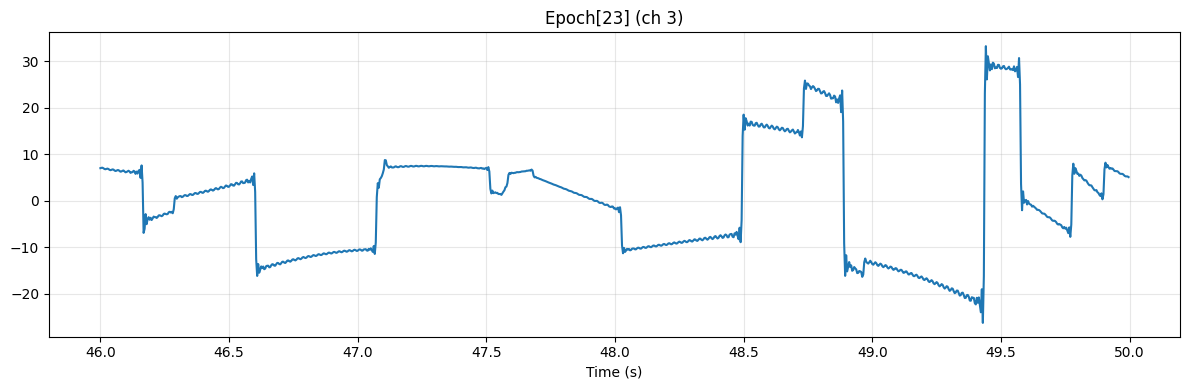

(54, 8, 1024)


In [18]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording_irregular(X,t, debug=True, ch_idx=3)


print(epochs.shape)

## baseline bandpower

In [19]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [20]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial",
            class_weight="balanced"
        )

        sub_tr = groups[tr]
        counts = pd.Series(sub_tr).value_counts()
        w = np.array([1.0 / counts[s] for s in sub_tr])

        clf.fit(Xtr, y_all[tr], sample_weight=w)


        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [21]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_win, y_win, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.368 | f1m=0.354
fold 02 | test_subject=S10 | n_win=158 | acc=0.285 | f1m=0.211
fold 03 | test_subject=S11 | n_win=183 | acc=0.268 | f1m=0.257
fold 04 | test_subject=S12 | n_win=167 | acc=0.299 | f1m=0.296
fold 05 | test_subject=S13 | n_win=153 | acc=0.438 | f1m=0.414


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 06 | test_subject=S14 | n_win=139 | acc=0.295 | f1m=0.256
fold 07 | test_subject=S15 | n_win=157 | acc=0.293 | f1m=0.259
fold 08 | test_subject=S2 | n_win=224 | acc=0.362 | f1m=0.337
fold 09 | test_subject=S3 | n_win=179 | acc=0.341 | f1m=0.295
fold 10 | test_subject=S4 | n_win=132 | acc=0.326 | f1m=0.310


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 11 | test_subject=S5 | n_win=174 | acc=0.224 | f1m=0.211
fold 12 | test_subject=S6 | n_win=152 | acc=0.197 | f1m=0.161
fold 13 | test_subject=S7 | n_win=149 | acc=0.121 | f1m=0.118
fold 14 | test_subject=S8 | n_win=196 | acc=0.291 | f1m=0.291
fold 15 | test_subject=S9 | n_win=231 | acc=0.251 | f1m=0.242

=== GLOBAL ===
acc: 0.2921826625386997
balanced_acc: 0.28105674660254054
f1_macro: 0.2790489390453984
f1_weighted: 0.2969833974016738
Confusion matrix:
 [[236 149 189 187]
 [130  85 130 127]
 [121  83 147 136]
 [169 186 222 287]]

Report:
               precision    recall  f1-score   support

           0      0.360     0.310     0.333       761
           1      0.169     0.180     0.174       472
           2      0.214     0.302     0.250       487
           3      0.389     0.332     0.359       864

    accuracy                          0.292      2584
   macro avg      0.283     0.281     0.279      2584
weighted avg      0.307     0.292     0.297      2584



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.368421,0.355213,0.354059,0.373672
1,S10,158,0.284810,0.225616,0.210732,0.265036
2,S11,183,0.267760,0.276727,0.257290,0.263859
3,S12,167,0.299401,0.302989,0.295915,0.301289
4,S13,153,0.437908,0.432130,0.413521,0.434317
5,S14,139,0.294964,0.258858,0.256335,0.284413
6,S15,157,0.292994,0.279537,0.258723,0.271849
7,S2,224,0.361607,0.379507,0.336748,0.384907
8,S3,179,0.340782,0.322522,0.295280,0.312420
9,S4,132,0.325758,0.332590,0.309839,0.338162



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.363 | f1m=0.355
fold 02 | test_subject=S10 | n_win=158 | acc=0.310 | f1m=0.216
fold 03 | test_subject=S11 | n_win=183 | acc=0.279 | f1m=0.272
fold 04 | test_subject=S12 | n_win=167 | acc=0.257 | f1m=0.230


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 05 | test_subject=S13 | n_win=153 | acc=0.438 | f1m=0.340
fold 06 | test_subject=S14 | n_win=139 | acc=0.367 | f1m=0.282
fold 07 | test_subject=S15 | n_win=157 | acc=0.299 | f1m=0.274
fold 08 | test_subject=S2 | n_win=224 | acc=0.478 | f1m=0.377


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 09 | test_subject=S3 | n_win=179 | acc=0.358 | f1m=0.293
fold 10 | test_subject=S4 | n_win=132 | acc=0.333 | f1m=0.313
fold 11 | test_subject=S5 | n_win=174 | acc=0.247 | f1m=0.215
fold 12 | test_subject=S6 | n_win=152 | acc=0.368 | f1m=0.338
fold 13 | test_subject=S7 | n_win=149 | acc=0.154 | f1m=0.146
fold 14 | test_subject=S8 | n_win=196 | acc=0.332 | f1m=0.319
fold 15 | test_subject=S9 | n_win=231 | acc=0.338 | f1m=0.304

=== GLOBAL ===
acc: 0.331656346749226
balanced_acc: 0.3037894665634143
f1_macro: 0.3022249701460131
f1_weighted: 0.33057665321518753
Confusion matrix:
 [[275  94 189 203]
 [142  70 132 128]
 [149  65 126 147]
 [185 100 193 386]]

Report:
               precision    recall  f1-score   support

           0      0.366     0.361     0.364       761
           1      0.213     0.148     0.175       472
           2      0.197     0.259     0.224       487
           3      0.447     0.447     0.447       864

    accuracy                          0.332      2584


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.363158,0.363248,0.355007,0.369929
1,S10,158,0.310127,0.245170,0.216040,0.272451
2,S11,183,0.278689,0.276899,0.272255,0.291008
3,S12,167,0.257485,0.255816,0.230167,0.239767
4,S13,153,0.437908,0.381960,0.340422,0.385021
5,S14,139,0.366906,0.315446,0.281746,0.322485
6,S15,157,0.299363,0.291121,0.273848,0.284798
7,S2,224,0.477679,0.381322,0.376836,0.501862
8,S3,179,0.357542,0.312361,0.292665,0.332589
9,S4,132,0.333333,0.327697,0.312840,0.349855


# solo 3 classi on the true dataset

In [22]:
LEVEL_TO_Y = {
    "natural":   0,
    "lowlevel":  1,
    "midlevel":  1,
    "highlevel": 2,
}


In [23]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"





## definiamo funzioni per la lettura e preprocessing dei dati

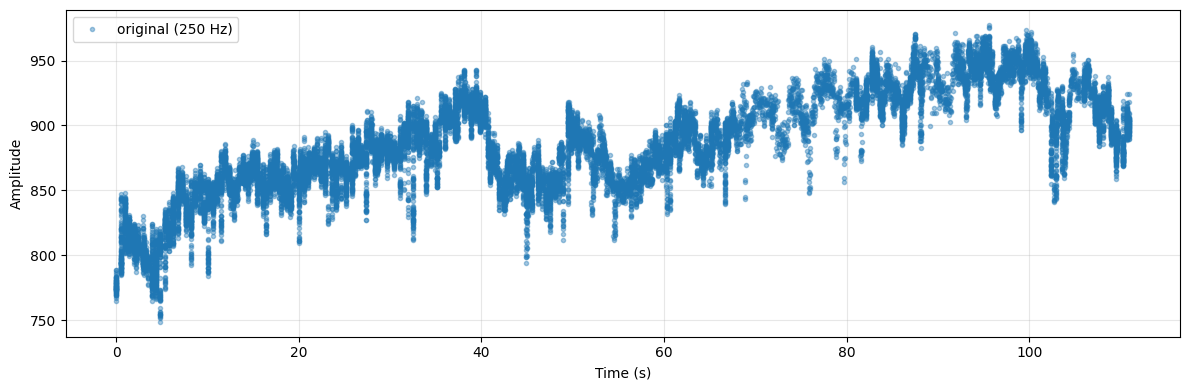

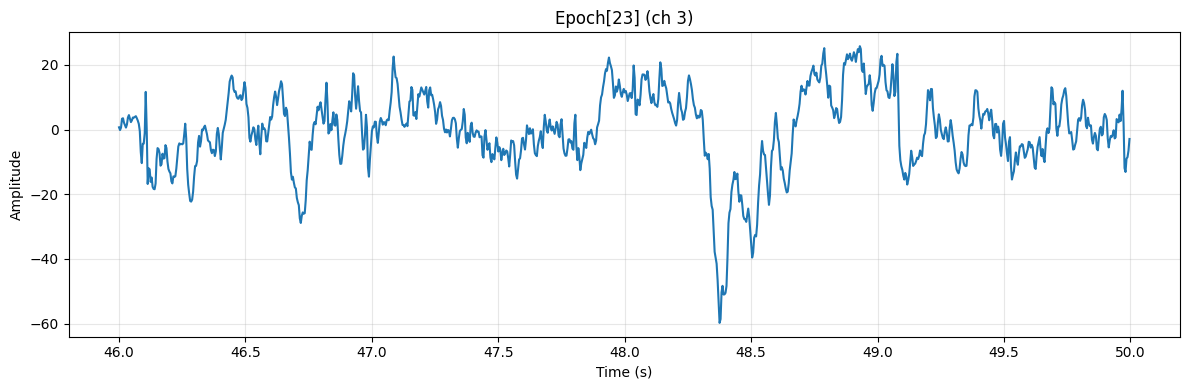

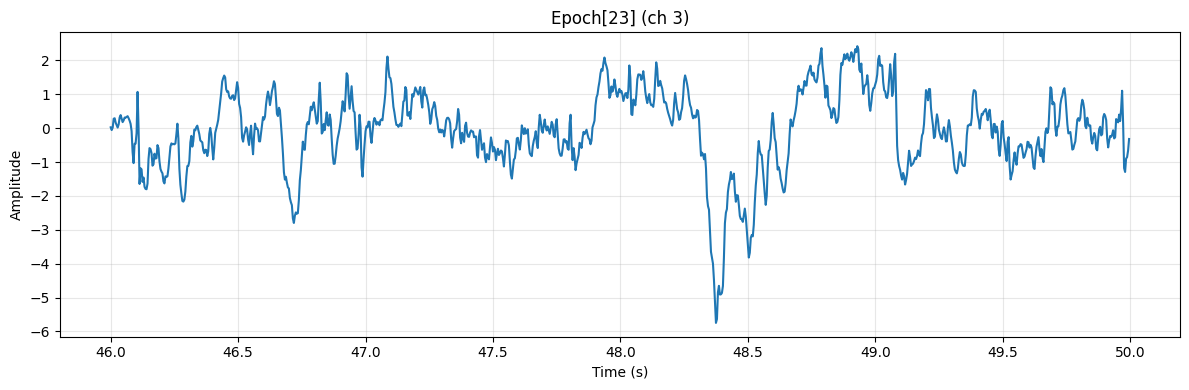

(43, 8, 1024)


In [24]:
task = "Stroop"
level = "highlevel"
subject = 3

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)

## build_all

In [25]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


In [26]:
print("unique y:", np.unique(y_all, return_counts=True))


unique y: (array([0, 1, 2]), array([835, 941, 744]))


## baseline bandpower

In [27]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [28]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [29]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 01 | test_subject=S1 | n_win=174 | acc=0.351 | f1m=0.255
fold 02 | test_subject=S10 | n_win=158 | acc=0.601 | f1m=0.598


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.559 | f1m=0.516
fold 04 | test_subject=S12 | n_win=166 | acc=0.548 | f1m=0.512


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.506 | f1m=0.419
fold 06 | test_subject=S14 | n_win=137 | acc=0.547 | f1m=0.494


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=156 | acc=0.808 | f1m=0.803


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.427 | f1m=0.229


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.614 | f1m=0.591
fold 10 | test_subject=S4 | n_win=126 | acc=0.421 | f1m=0.342


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.394 | f1m=0.407
fold 12 | test_subject=S6 | n_win=145 | acc=0.290 | f1m=0.242
fold 13 | test_subject=S7 | n_win=146 | acc=0.534 | f1m=0.469


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=197 | acc=0.325 | f1m=0.318
fold 15 | test_subject=S9 | n_win=229 | acc=0.572 | f1m=0.531

=== GLOBAL ===
acc: 0.49722222222222223
balanced_acc: 0.4906531862172379
f1_macro: 0.4888562856417707
f1_weighted: 0.49338877582210194
Confusion matrix:
 [[513 195 127]
 [213 487 241]
 [147 344 253]]

Report:
               precision    recall  f1-score   support

           0      0.588     0.614     0.601       835
           1      0.475     0.518     0.495       941
           2      0.407     0.340     0.371       744

    accuracy                          0.497      2520
   macro avg      0.490     0.491     0.489      2520
weighted avg      0.492     0.497     0.493      2520



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.350575,0.292785,0.255231,0.299717
1,S10,158,0.601266,0.606920,0.598033,0.596897
2,S11,179,0.558659,0.527623,0.516464,0.541103
3,S12,166,0.548193,0.532062,0.512145,0.517054
4,S13,154,0.506494,0.494971,0.418823,0.426318
5,S14,137,0.547445,0.571481,0.494067,0.469577
6,S15,156,0.807692,0.795015,0.803404,0.806060
7,S2,225,0.426667,0.287747,0.228595,0.330259
8,S3,153,0.614379,0.594326,0.591034,0.604021
9,S4,126,0.420635,0.387982,0.341951,0.377233



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.333 | f1m=0.241
fold 02 | test_subject=S10 | n_win=158 | acc=0.658 | f1m=0.658
fold 03 | test_subject=S11 | n_win=179 | acc=0.547 | f1m=0.490


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=166 | acc=0.566 | f1m=0.499
fold 05 | test_subject=S13 | n_win=154 | acc=0.481 | f1m=0.395


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=137 | acc=0.555 | f1m=0.542
fold 07 | test_subject=S15 | n_win=156 | acc=0.821 | f1m=0.819


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.467 | f1m=0.326


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 09 | test_subject=S3 | n_win=153 | acc=0.601 | f1m=0.599
fold 10 | test_subject=S4 | n_win=126 | acc=0.651 | f1m=0.661


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.440 | f1m=0.448


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=145 | acc=0.407 | f1m=0.278


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=146 | acc=0.589 | f1m=0.541


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=197 | acc=0.411 | f1m=0.409
fold 15 | test_subject=S9 | n_win=229 | acc=0.559 | f1m=0.513

=== GLOBAL ===
acc: 0.5325396825396825
balanced_acc: 0.5238514828695083
f1_macro: 0.5210609519783788
f1_weighted: 0.5263780492606414
Confusion matrix:
 [[546 184 105]
 [199 541 201]
 [135 354 255]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Report:
               precision    recall  f1-score   support

           0      0.620     0.654     0.637       835
           1      0.501     0.575     0.536       941
           2      0.455     0.343     0.391       744

    accuracy                          0.533      2520
   macro avg      0.525     0.524     0.521      2520
weighted avg      0.527     0.533     0.526      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.333333,0.276190,0.241143,0.285143
1,S10,158,0.658228,0.663061,0.657674,0.656481
2,S11,179,0.547486,0.512108,0.490165,0.515707
3,S12,166,0.566265,0.540221,0.498990,0.509219
4,S13,154,0.480519,0.471983,0.394732,0.404066
5,S14,137,0.554745,0.574945,0.542326,0.520980
6,S15,156,0.820513,0.814559,0.819278,0.820113
7,S2,225,0.466667,0.354941,0.325898,0.408516
8,S3,153,0.601307,0.600202,0.599041,0.599182
9,S4,126,0.650794,0.688383,0.660538,0.634384


# 3 classi on true datset using interpolation

In [30]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording_irregular(X, t=t)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2584, 8, 1024) y_all: (2584,) unique rec: 60


## baseline bandpower

In [31]:
import numpy as np
from scipy.signal import welch

BANDS = {
    "delta": (1.0, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "beta":  (13.0, 30.0),
    "gamma": (30.0, 45.0),
}

def bandpower_features(X_w, fs=256, bands=BANDS, relative=False, logpow=True):
    """
    X_w: (Nwin, C, T)
    return: (Nwin, C*nbands)
    """
    N, C, T = X_w.shape
    nb = len(bands)
    feats = np.zeros((N, C, nb), dtype=np.float32)

    nperseg = min(T, int(2*fs))  # 2 sec
    for i in range(N):
        for ch in range(C):
            f, Pxx = welch(X_w[i, ch], fs=fs, nperseg=nperseg, noverlap=nperseg//2)

            m_tot = (f >= 1.0) & (f <= 45.0)
            total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12

            for b_i, (name, (lo, hi)) in enumerate(bands.items()):
                m = (f >= lo) & (f <= hi)
                bp = np.trapz(Pxx[m], f[m]) + 1e-12
                if relative:
                    bp = bp / total
                if logpow:
                    bp = np.log(bp)
                feats[i, ch, b_i] = bp

    return feats.reshape(N, C*nb)


In [32]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

def loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False):
    """
    LOSO: leave-one-subject-out sulle finestre.
    groups = meta['subject'] (S1..S15)
    """
    groups = np.asarray(meta["subject"]).astype(str)

    F = bandpower_features(X_all, fs=fs, relative=relative, logpow=True)

    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []
    rows = []

    n_classes = int(np.max(y_all) + 1)

    for fold, (tr, te) in enumerate(logo.split(F, y_all, groups=groups), 1):
        test_subject = groups[te][0]

        scaler = StandardScaler()
        Xtr = scaler.fit_transform(F[tr])
        Xte = scaler.transform(F[te])

        clf = LogisticRegression(
            max_iter=5000,
            solver="lbfgs",
            multi_class="multinomial"
        )
        clf.fit(Xtr, y_all[tr])
        pred = clf.predict(Xte)

        acc  = accuracy_score(y_all[te], pred)
        bacc = balanced_accuracy_score(y_all[te], pred)
        f1m  = f1_score(y_all[te], pred, average="macro")
        f1w  = f1_score(y_all[te], pred, average="weighted")

        rows.append({
            "subject": test_subject,
            "n_test_windows": len(te),
            "acc": acc,
            "balanced_acc": bacc,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        y_true_all.append(y_all[te])
        y_pred_all.append(pred)

        print(f"fold {fold:02d} | test_subject={test_subject} | n_win={len(te)} | acc={acc:.3f} | f1m={f1m:.3f}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(n_classes)))

    print("\n=== GLOBAL ===")
    print("acc:", accuracy_score(y_true_all, y_pred_all))
    print("balanced_acc:", balanced_accuracy_score(y_true_all, y_pred_all))
    print("f1_macro:", f1_score(y_true_all, y_pred_all, average="macro"))
    print("f1_weighted:", f1_score(y_true_all, y_pred_all, average="weighted"))
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(y_true_all, y_pred_all, digits=3))

    df = pd.DataFrame(rows).sort_values("subject").reset_index(drop=True)
    return df, cm


In [33]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.505 | f1m=0.474
fold 02 | test_subject=S10 | n_win=158 | acc=0.278 | f1m=0.247
fold 03 | test_subject=S11 | n_win=183 | acc=0.432 | f1m=0.402


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=167 | acc=0.371 | f1m=0.339
fold 05 | test_subject=S13 | n_win=153 | acc=0.497 | f1m=0.458


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 06 | test_subject=S14 | n_win=139 | acc=0.367 | f1m=0.365
fold 07 | test_subject=S15 | n_win=157 | acc=0.344 | f1m=0.345


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=224 | acc=0.442 | f1m=0.403
fold 09 | test_subject=S3 | n_win=179 | acc=0.514 | f1m=0.505


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.333 | f1m=0.282
fold 11 | test_subject=S5 | n_win=174 | acc=0.316 | f1m=0.297


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 12 | test_subject=S6 | n_win=152 | acc=0.257 | f1m=0.256
fold 13 | test_subject=S7 | n_win=149 | acc=0.181 | f1m=0.169


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=196 | acc=0.418 | f1m=0.395
fold 15 | test_subject=S9 | n_win=231 | acc=0.385 | f1m=0.361

=== GLOBAL ===
acc: 0.38273993808049533
balanced_acc: 0.37359808822466406
f1_macro: 0.3690070800798065
f1_weighted: 0.3747368884325663
Confusion matrix:
 [[395 355 114]
 [311 431 217]
 [222 376 163]]

Report:
               precision    recall  f1-score   support

           0      0.426     0.457     0.441       864
           1      0.371     0.449     0.406       959
           2      0.330     0.214     0.260       761

    accuracy                          0.383      2584
   macro avg      0.376     0.374     0.369      2584
weighted avg      0.377     0.383     0.375      2584



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.505263,0.476935,0.474261,0.485702
1,S10,158,0.278481,0.292298,0.247352,0.239824
2,S11,183,0.431694,0.414756,0.401662,0.411167
3,S12,167,0.371257,0.346279,0.338768,0.352815
4,S13,153,0.496732,0.502914,0.458297,0.456394
5,S14,139,0.366906,0.377304,0.364729,0.361054
6,S15,157,0.343949,0.340748,0.344842,0.352798
7,S2,224,0.441964,0.433533,0.402928,0.443616
8,S3,179,0.513966,0.522158,0.505005,0.500590
9,S4,132,0.333333,0.339909,0.281710,0.279456



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=190 | acc=0.500 | f1m=0.450
fold 02 | test_subject=S10 | n_win=158 | acc=0.272 | f1m=0.237
fold 03 | test_subject=S11 | n_win=183 | acc=0.448 | f1m=0.423


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 04 | test_subject=S12 | n_win=167 | acc=0.431 | f1m=0.391
fold 05 | test_subject=S13 | n_win=153 | acc=0.477 | f1m=0.435
fold 06 | test_subject=S14 | n_win=139 | acc=0.388 | f1m=0.386


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=157 | acc=0.350 | f1m=0.344
fold 08 | test_subject=S2 | n_win=224 | acc=0.491 | f1m=0.421
fold 09 | test_subject=S3 | n_win=179 | acc=0.464 | f1m=0.456


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 10 | test_subject=S4 | n_win=132 | acc=0.333 | f1m=0.298
fold 11 | test_subject=S5 | n_win=174 | acc=0.339 | f1m=0.317
fold 12 | test_subject=S6 | n_win=152 | acc=0.408 | f1m=0.396


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 13 | test_subject=S7 | n_win=149 | acc=0.208 | f1m=0.180
fold 14 | test_subject=S8 | n_win=196 | acc=0.454 | f1m=0.422
fold 15 | test_subject=S9 | n_win=231 | acc=0.385 | f1m=0.357

=== GLOBAL ===
acc: 0.40286377708978327
balanced_acc: 0.3916815686642892
f1_macro: 0.3831570929047454
f1_weighted: 0.39056780728009755
Confusion matrix:
 [[426 326 112]
 [316 465 178]
 [248 363 150]]

Report:
               precision    recall  f1-score   support

           0      0.430     0.493     0.460       864
           1      0.403     0.485     0.440       959
           2      0.341     0.197     0.250       761

    accuracy                          0.403      2584
   macro avg      0.391     0.392     0.383      2584
weighted avg      0.394     0.403     0.391      2584



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,190,0.500000,0.459854,0.449603,0.467538
1,S10,158,0.272152,0.287121,0.236588,0.228737
2,S11,183,0.448087,0.431943,0.423193,0.431309
3,S12,167,0.431138,0.400864,0.391042,0.407772
4,S13,153,0.477124,0.486870,0.435455,0.431742
5,S14,139,0.388489,0.397394,0.385685,0.383426
6,S15,157,0.350318,0.345207,0.344340,0.352999
7,S2,224,0.491071,0.464969,0.420849,0.479871
8,S3,179,0.463687,0.468575,0.455887,0.453596
9,S4,132,0.333333,0.338497,0.298490,0.297873


# solo 2 classi on the true dataset

In [34]:
LEVEL_TO_Y = {
    "natural":   0,
    "lowlevel":  1,
    "midlevel":  1,
    "highlevel": 1,
}


## build_all

In [35]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


## baseline bandpower

In [36]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fi

fold 01 | test_subject=S1 | n_win=174 | acc=0.644 | f1m=0.457
fold 02 | test_subject=S10 | n_win=158 | acc=0.728 | f1m=0.701
fold 03 | test_subject=S11 | n_win=179 | acc=0.810 | f1m=0.755
fold 04 | test_subject=S12 | n_win=166 | acc=0.855 | f1m=0.822
fold 05 | test_subject=S13 | n_win=154 | acc=0.812 | f1m=0.790


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

fold 06 | test_subject=S14 | n_win=137 | acc=0.942 | f1m=0.926
fold 07 | test_subject=S15 | n_win=156 | acc=0.942 | f1m=0.925
fold 08 | test_subject=S2 | n_win=225 | acc=0.444 | f1m=0.422
fold 09 | test_subject=S3 | n_win=153 | acc=0.810 | f1m=0.779


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

fold 10 | test_subject=S4 | n_win=126 | acc=0.762 | f1m=0.490
fold 11 | test_subject=S5 | n_win=175 | acc=0.754 | f1m=0.676
fold 12 | test_subject=S6 | n_win=145 | acc=0.676 | f1m=0.500
fold 13 | test_subject=S7 | n_win=146 | acc=0.856 | f1m=0.812
fold 14 | test_subject=S8 | n_win=197 | acc=0.584 | f1m=0.546
fold 15 | test_subject=S9 | n_win=229 | acc=0.825 | f1m=0.815

=== GLOBAL ===
acc: 0.7515873015873016
balanced_acc: 0.7042911210220508
f1_macro: 0.710232883475971
f1_weighted: 0.7471564710753733
Confusion matrix:
 [[ 471  364]
 [ 262 1423]]

Report:
               precision    recall  f1-score   support

           0      0.643     0.564     0.601       835
           1      0.796     0.845     0.820      1685

    accuracy                          0.752      2520
   macro avg      0.719     0.704     0.710      2520
weighted avg      0.745     0.752     0.747      2520



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.643678,0.464827,0.457126,0.621731
1,S10,158,0.727848,0.718498,0.701428,0.735156
2,S11,179,0.810056,0.734375,0.754755,0.787936
3,S12,166,0.855422,0.814408,0.821920,0.853560
4,S13,154,0.811688,0.806211,0.790476,0.815584
5,S14,137,0.941606,0.902439,0.925946,0.939617
6,S15,156,0.942308,0.904627,0.924964,0.940689
7,S2,225,0.444444,0.440316,0.422354,0.424864
8,S3,153,0.810458,0.777083,0.778648,0.809909
9,S4,126,0.761905,0.531250,0.490016,0.673245


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12



=== Baseline 2: LOG bandpower (relative) ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

fold 01 | test_subject=S1 | n_win=174 | acc=0.632 | f1m=0.440
fold 02 | test_subject=S10 | n_win=158 | acc=0.785 | f1m=0.761
fold 03 | test_subject=S11 | n_win=179 | acc=0.810 | f1m=0.755
fold 04 | test_subject=S12 | n_win=166 | acc=0.867 | f1m=0.835
fold 05 | test_subject=S13 | n_win=154 | acc=0.675 | f1m=0.663


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

fold 06 | test_subject=S14 | n_win=137 | acc=0.912 | f1m=0.885
fold 07 | test_subject=S15 | n_win=156 | acc=0.917 | f1m=0.895
fold 08 | test_subject=S2 | n_win=225 | acc=0.516 | f1m=0.511
fold 09 | test_subject=S3 | n_win=153 | acc=0.797 | f1m=0.761
fold 10 | test_subject=S4 | n_win=126 | acc=0.929 | f1m=0.909


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

fold 11 | test_subject=S5 | n_win=175 | acc=0.766 | f1m=0.696
fold 12 | test_subject=S6 | n_win=145 | acc=0.676 | f1m=0.457
fold 13 | test_subject=S7 | n_win=146 | acc=0.856 | f1m=0.801
fold 14 | test_subject=S8 | n_win=197 | acc=0.645 | f1m=0.601
fold 15 | test_subject=S9 | n_win=229 | acc=0.834 | f1m=0.828

=== GLOBAL ===
acc: 0.7638888888888888
balanced_acc: 0.7204374633522272
f1_macro: 0.7260084229476809
f1_weighted: 0.7603717058185739
Confusion matrix:
 [[ 494  341]
 [ 254 1431]]

Report:
               precision    recall  f1-score   support

           0      0.660     0.592     0.624       835
           1      0.808     0.849     0.828      1685

    accuracy                          0.764      2520
   macro avg      0.734     0.720     0.726      2520
weighted avg      0.759     0.764     0.760      2520



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.632184,0.449134,0.439614,0.609529
1,S10,158,0.784810,0.776634,0.760862,0.789600
2,S11,179,0.810056,0.734375,0.754755,0.787936
3,S12,166,0.867470,0.822955,0.834601,0.864805
4,S13,154,0.675325,0.701454,0.662518,0.687278
5,S14,137,0.912409,0.853659,0.884874,0.907477
6,S15,156,0.916667,0.886769,0.894895,0.915747
7,S2,225,0.515556,0.513636,0.510879,0.511942
8,S3,153,0.797386,0.756250,0.760563,0.795545
9,S4,126,0.928571,0.921210,0.908511,0.929591


# cambiando preprocessing

In [40]:
def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza

    # 1) preprocess leggero a 250 (opzionale, ma ok)
    x = detrend(X, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # 2) resample 250 -> 256
    x = resample_to(x, fs_in, FS_OUT)               # (T256, C)
    t_256 = t[0] + np.arange(x.shape[0]) / FS_OUT   # (T256,)

    # 3) filtri a 256 (coerenti col segnale)
    x = bandpass(x, FS_OUT)
    x = notch50(x, FS_OUT)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t, X[:, ch_idx], '.', alpha=0.4, label="original (250 Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4) epoche a 256
    epochs_tc = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs_tc.shape[0] == 0:
        win = int(EPOCH_SEC * FS_OUT)
        return np.empty((0, X.shape[1], win), dtype=np.float32), None

    epochs = np.transpose(epochs_tc, (0, 2, 1))  # (N, C, win)

    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_256[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


    # 5) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)
    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs



## build_all

In [42]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


## baseline bandpower

In [43]:
print("=== Baseline 1: LOG bandpower (absolute) ===")
df_abs, cm_abs = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=False)
display(df_abs)

print("\n=== Baseline 2: LOG bandpower (relative) ===")
df_rel, cm_rel = loso_bandpower_eval_from_buildall(X_all, y_all, meta, fs=256, relative=True)
display(df_rel)


=== Baseline 1: LOG bandpower (absolute) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.241 | f1m=0.201
fold 02 | test_subject=S10 | n_win=158 | acc=0.557 | f1m=0.432


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.397 | f1m=0.355
fold 04 | test_subject=S12 | n_win=166 | acc=0.361 | f1m=0.297


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.383 | f1m=0.282
fold 06 | test_subject=S14 | n_win=137 | acc=0.533 | f1m=0.348
fold 07 | test_subject=S15 | n_win=156 | acc=0.538 | f1m=0.438


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 08 | test_subject=S2 | n_win=225 | acc=0.444 | f1m=0.178
fold 09 | test_subject=S3 | n_win=153 | acc=0.464 | f1m=0.366
fold 10 | test_subject=S4 | n_win=126 | acc=0.254 | f1m=0.183


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 11 | test_subject=S5 | n_win=175 | acc=0.406 | f1m=0.303
fold 12 | test_subject=S6 | n_win=145 | acc=0.283 | f1m=0.203
fold 13 | test_subject=S7 | n_win=146 | acc=0.486 | f1m=0.417


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=197 | acc=0.360 | f1m=0.257
fold 15 | test_subject=S9 | n_win=229 | acc=0.559 | f1m=0.346

=== GLOBAL ===
acc: 0.42142857142857143
balanced_acc: 0.3688234432611773
f1_macro: 0.3619294913279165
f1_weighted: 0.408007587833317
Confusion matrix:
 [[353 109 132 150]
 [203  59  84 113]
 [142  99 107 134]
 [128  69  95 543]]

Report:
               precision    recall  f1-score   support

           0      0.427     0.474     0.450       744
           1      0.176     0.129     0.148       459
           2      0.256     0.222     0.238       482
           3      0.578     0.650     0.612       835

    accuracy                          0.421      2520
   macro avg      0.359     0.369     0.362      2520
weighted avg      0.399     0.421     0.408      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.241379,0.237960,0.201263,0.211156
1,S10,158,0.556962,0.455991,0.431548,0.510063
2,S11,179,0.396648,0.357280,0.355444,0.414656
3,S12,166,0.361446,0.367557,0.296528,0.318137
4,S13,154,0.383117,0.345227,0.281939,0.309028
5,S14,137,0.532847,0.420599,0.348118,0.437341
6,S15,156,0.538462,0.487956,0.438279,0.469031
7,S2,225,0.444444,0.232274,0.177675,0.335488
8,S3,153,0.464052,0.409312,0.365552,0.412937
9,S4,126,0.253968,0.300654,0.182688,0.227642



=== Baseline 2: LOG bandpower (relative) ===


/tmp/ipython-input-1501374552.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx[m_tot], f[m_tot]) + 1e-12
/tmp/ipython-input-1501374552.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(Pxx[m], f[m]) + 1e-12
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.war

fold 01 | test_subject=S1 | n_win=174 | acc=0.207 | f1m=0.192
fold 02 | test_subject=S10 | n_win=158 | acc=0.525 | f1m=0.406


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 03 | test_subject=S11 | n_win=179 | acc=0.397 | f1m=0.310
fold 04 | test_subject=S12 | n_win=166 | acc=0.367 | f1m=0.323


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 05 | test_subject=S13 | n_win=154 | acc=0.344 | f1m=0.231
fold 06 | test_subject=S14 | n_win=137 | acc=0.526 | f1m=0.350


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 07 | test_subject=S15 | n_win=156 | acc=0.615 | f1m=0.543
fold 08 | test_subject=S2 | n_win=225 | acc=0.449 | f1m=0.214
fold 09 | test_subject=S3 | n_win=153 | acc=0.471 | f1m=0.378
fold 10 | test_subject=S4 | n_win=126 | acc=0.500 | f1m=0.477
fold 11 | test_subject=S5 | n_win=175 | acc=0.411 | f1m=0.343


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

fold 12 | test_subject=S6 | n_win=145 | acc=0.386 | f1m=0.357
fold 13 | test_subject=S7 | n_win=146 | acc=0.452 | f1m=0.409


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


fold 14 | test_subject=S8 | n_win=197 | acc=0.401 | f1m=0.272
fold 15 | test_subject=S9 | n_win=229 | acc=0.541 | f1m=0.345

=== GLOBAL ===
acc: 0.4384920634920635
balanced_acc: 0.38581150718056256
f1_macro: 0.3791365579529847
f1_weighted: 0.4209122468197825
Confusion matrix:
 [[380  65 130 169]
 [176  78 100 105]
 [177  50 100 155]
 [159  34  95 547]]

Report:
               precision    recall  f1-score   support

           0      0.426     0.511     0.465       744
           1      0.344     0.170     0.227       459
           2      0.235     0.207     0.221       482
           3      0.560     0.655     0.604       835

    accuracy                          0.438      2520
   macro avg      0.391     0.386     0.379      2520
weighted avg      0.419     0.438     0.421      2520



,subject,n_test_windows,acc,balanced_acc,f1_macro,f1_weighted
0,S1,174,0.206897,0.205180,0.192469,0.196990
1,S10,158,0.525316,0.434859,0.405896,0.479363
2,S11,179,0.396648,0.334908,0.309571,0.379273
3,S12,166,0.367470,0.349663,0.322786,0.354464
4,S13,154,0.344156,0.309186,0.231180,0.254134
5,S14,137,0.525547,0.413176,0.350165,0.439804
6,S15,156,0.615385,0.571174,0.543163,0.571963
7,S2,225,0.448889,0.242940,0.213685,0.367282
8,S3,153,0.470588,0.412302,0.378132,0.422429
9,S4,126,0.500000,0.528313,0.477080,0.496249


# conclusione



### Metriche principali (LOSO, Logistic Regression)

| Task                | Classi                         | Feature        | Accuracy | Balanced Acc. | F1 Macro |
| ------------------- | ------------------------------ | -------------- | -------- | ------------- | -------- |
| Workload fine       | 4 (neutral / low / mid / high) | Band power     | 0.44     | 0.40          | 0.39     |
| Workload fine       | 4                              | Relative power | 0.44     | 0.39          | 0.39     |
| Workload intermedio | 3 (neutral / low–mid / high)   | Band power     | 0.50     | 0.49          | 0.49     |
| Workload intermedio | 3                              | Relative power | **0.53** | **0.52**      | **0.52** |
| Workload binario    | 2 (neutral vs task)            | Band power     | 0.75     | 0.70          | 0.71     |
| Workload binario    | 2                              | Relative power | **0.76** | **0.72**      | **0.73** |



Le prestazioni mostrano un andamento coerente al variare della granularità del task. Nel caso di **4 classi**, le feature spettrali producono risultati limitati ma sopra il livello casuale, evidenziando la difficoltà di separare livelli adiacenti di workload in un contesto cross-soggetto. La **relative power** non introduce miglioramenti significativi in questo setting.

Riducendo il problema a **3 classi**, si osserva un incremento consistente delle prestazioni, con un ulteriore beneficio derivante dall’uso della relative power, suggerendo una maggiore robustezza rispetto alla variabilità inter-soggetto.

Nel caso **binario (neutral vs task)**, le prestazioni aumentano sensibilmente, indicando che il segnale EEG contiene informazione discriminativa chiara per la distinzione tra stato neutro e presenza di attività cognitiva.

Nel complesso, i risultati confermano che la difficoltà del problema cresce con la granularità della suddivisione del workload e che modelli basati su feature spettrali semplici risultano insufficienti per una stima fine del carico cognitivo, motivando l’impiego di rappresentazioni più espressive come EEGPT.




